# Mapping mining areas with DINO & SAM

This notebook aims to detect and map mining areas using the Grounding DINO model for Object Detection, the Segment Anything Model (SAM) for segmentation. 

In [1]:
import leafmap
from samgeo import split_raster
from samgeo.text_sam import LangSAM
import os
import torch
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import glob

import sys
sys.path.append('../..')

from src.data.get_satellite_images import ReadSTAC
from src.visualization.visualize import plot_multiple_masks_on_images, plot_mask_on_image, plot_S2_geotiff_rgb
from src.utils import geotiff_to_PIL, normalize_geotiff, merge_geotiffs

# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# get root directory
root = os.path.dirname(os.path.dirname(os.path.abspath('')))
root

cpu


'/home/simonjasansky/programming/mine-segmentation'

## Setup

In [2]:
chip_folder = root + "/data/processed/chips/train/chips"
chip_mask_folder = root + "/data/processed/chips/train/masks"
output_folder = root + "/data/output"

# old
image_folder = root + "/data/processed/files/train"
normalized_image_folder = root + "/data/interim/samgeo"
tiles_dir = root + "/data/interim/samgeo/tiles"
masks_dir = root + "/data/interim/samgeo/masks"

# Testing

In [3]:
from src.models.samgeo.model import MineSamGeo

model = MineSamGeo(
    model_type="vit_b",
    chips_dir=chip_folder,
    output_dir=output_folder
)

final text_encoder_type: bert-base-uncased


In [4]:
chip_path = model.get_chip_path(4)

bboxes = model.predict_dino(
    chip_path=chip_path,
    text_prompt="mine", 
    box_threshold=0.2, 
    text_threshold=0.2
)
bboxes

(tensor([[227.2825,   1.9929, 351.9253, 121.2719]]),
 tensor([0.2060]),
 ['mine'])

In [5]:
model.predict_sam()

AttributeError: 'MineSamGeo' object has no attribute 'image_np'

### Load a chip

In [8]:
chip_path = glob.glob(chip_folder + "/*.tif")[1]
chip_path

'/home/simonjasansky/programming/mine-segmentation/data/processed/chips/train/chips/1167_S2A_MSIL2A_20190424T082611_R021_T33JYF_20201105T165235_img_chip_2.tif'

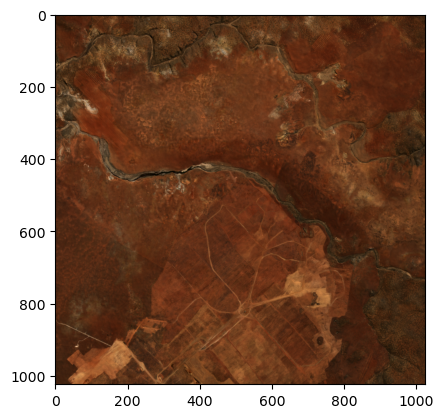

In [6]:
plot_S2_geotiff_rgb(chip_path)

In [20]:
# import numpy as np
# from PIL import Image
# import glob

# # load numpy array from chips dir
# chips_dir = root + "/data/processed/chips/train/chips"
# chip_files = glob.glob(os.path.join(chips_dir, "*.npy"))
# chip_path = chip_files[3]

# chip_array = np.load(chip_path)
# print(chip_array.shape)

# # normalize
# chip_array = (chip_array - chip_array.min()) / (chip_array.max() - chip_array.min()) * 255
# chip_array = chip_array.astype(np.uint8)
# print(chip_array.shape)

# # convert to PIL
# chip_pil = Image.fromarray(chip_array.transpose(1, 2, 0))
# chip_pil

In [11]:
nchip_path = chip_folder + "/" + os.path.basename(chip_path).replace(".tif", "_normalized.tif")
normalize_geotiff(chip_path, chip_path)

### Initialize LangSAM class

The initialization of the LangSAM class might take a few minutes. The initialization downloads the model weights and sets up the model for inference.

In [13]:
sam = LangSAM(model_type="vit_b")

final text_encoder_type: bert-base-uncased


## Object detection with DINO

Part of the model prediction includes setting appropriate thresholds for object detection and text association with the detected objects. These threshold values range from 0 to 1 and are set while calling the predict method of the LangSAM class.

`box_threshold`: This value is used for object detection in the image. A higher value makes the model more selective, identifying only the most confident object instances, leading to fewer overall detections. A lower value, conversely, makes the model more tolerant, leading to increased detections, including potentially less confident ones.

`text_threshold`: This value is used to associate the detected objects with the provided text prompt. A higher value requires a stronger association between the object and the text prompt, leading to more precise but potentially fewer associations. A lower value allows for looser associations, which could increase the number of associations but also introduce less precise matches.

Remember to test different threshold values on your specific data. The optimal threshold can vary depending on the quality and nature of your images, as well as the specificity of your text prompts. Make sure to choose a balance that suits your requirements, whether that's precision or recall.

In [14]:
text_prompt = "mine"

In [15]:
sam.predict_dino(
    image=chip_path,
    text_prompt=text_prompt,
    box_threshold=0.2,
    text_threshold=0.2,
)

AttributeError: 'str' object has no attribute 'size'

In [16]:
# Predict on tiles
sam.predict(
    image=chip_path,
    output=masks_dir + "/tile_0.tif",
    text_prompt=text_prompt,
    box_threshold=0.2,
    text_threshold=0.2,
    mask_multiplier=255,
    dtype="uint8",
)

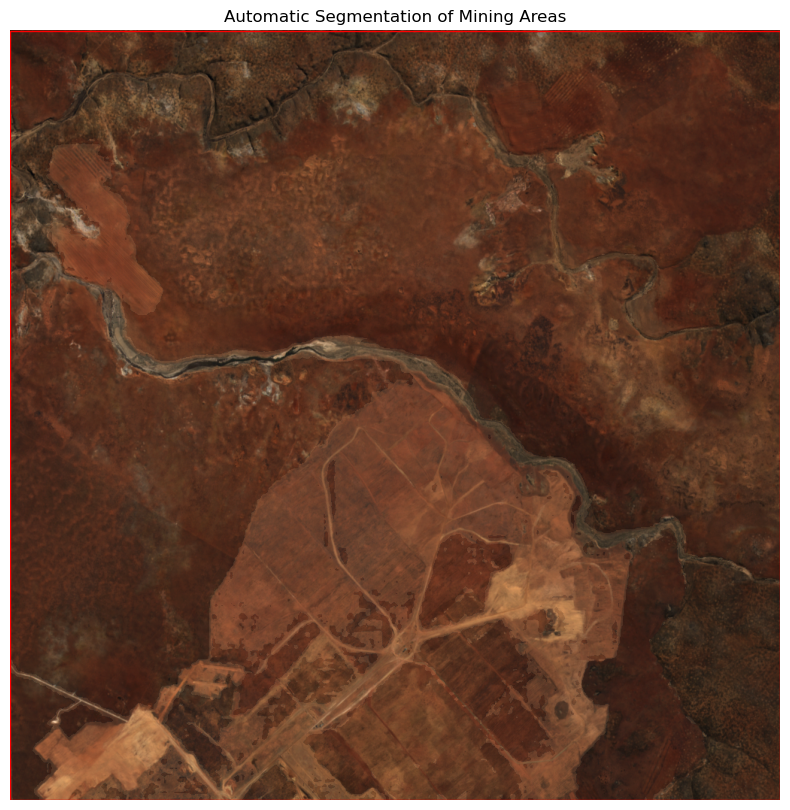

In [17]:
sam.show_anns(
    cmap="Blues",
    box_color="red",
    title="Automatic Segmentation of Mining Areas",
    blend=True,
    alpha=0.1
)

In [92]:
sam.save_boxes("boxes.json")

## Segmentation with SAM

In [ ]:
sam.predict(image, text_prompt, box_threshold=0.3, text_threshold=0.3)

## Visualize the results

Show the result with bounding boxes on the map.

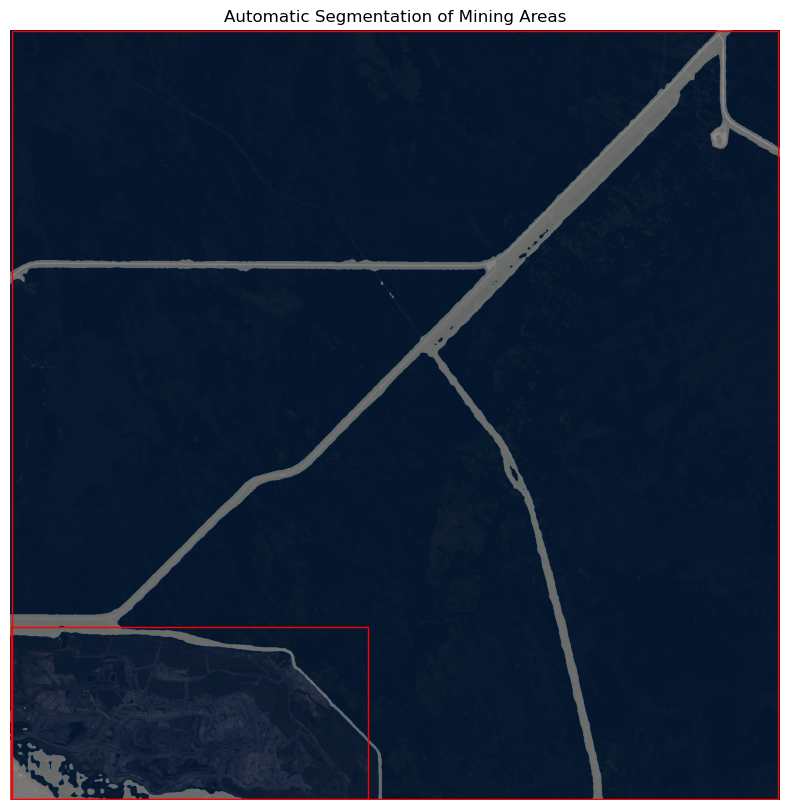

In [ ]:
sam.show_anns(
    cmap="Blues",
    box_color="red",
    title="Automatic Segmentation of Mining Areas",
    blend=True,
)

Show the result without bounding boxes on the map.

In [ ]:
sam.show_anns(
    cmap="Blues",
    add_boxes=False,
    alpha=0.5,
    title="Automatic Segmentation of Mining Areas",
)

Show the result as a grayscale image.

In [ ]:
sam.show_anns(
    cmap="Greys_r",
    add_boxes=False,
    alpha=1,
    title="Automatic Segmentation of Mining areas",
    blend=False,
    output="minearea.tif",
)

Convert the result to a vector format.  

In [ ]:
sam.raster_to_vector("minearea.tif", "minearea.shp")

Show the results on the interactive map.

In [ ]:
m.add_raster("minearea.tif", layer_name="minearea", palette="Blues", opacity=0.5, nodata=0)
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector("minearea.shp", layer_name="Vector", style=style)
m

In [9]:
# Load the georeferenced image
from PIL import Image
with rasterio.open(chip_path) as src:
    chip_np = src.read().transpose(
        (1, 2, 0)
    )  # Convert rasterio image to numpy array
    # self.model.transform = src.transform  # Save georeferencing information
    # self.model.crs = src.crs  # Save the Coordinate Reference System
    chip_pil = Image.fromarray(
        chip_np[:, :, :3]
    )  # Convert numpy array to PIL image, excluding the alpha channel

chip_pil.size

(1024, 1024)